# COMP 2002 Intro to AI
## Assignment

This assignment contributes 70% of the overall module mark for COMP2002 and is an individual
assignment. You must submit the deliverables to the DLE by the specified submission dates.

The coursework has two parts – one is a machine learning exercise and the second is about
evolutionary computation. You must complete and submit both parts. Each part is worth 50% of
the coursework mark.

# Part 1 - ML

You have been provided with datasets relating to the energy efficiency of buildings. Your task is to
train regression models that predict two indicators of energy efficiency based on 8 numerical inputs.

## Task 1.1 - Data preparation 

The first phase of the work requires you to load the data you have been provided with into your Python
program. Before the data can be used to train and test your models you must first prepare it – this
means that the inputs must be normalized. There is no missing data in the dataset.

(10% of total mark)

## Task 1.2 - Regression 

Having prepared the data you must now build a regression tool that can predict new points. Use the
following regression implementations within the scikit-learn package to construct predictors for the
dataset:

- Random Forest (sklearn.ensemble.RandomForestRegressor)
- Neural Network (sklearn.neural_network.MLPRegressor)
- Support Vector Machine (sklearn.svm.SVR)

You must demonstrate that each regressor is capable of providing a prediction for a given input.

(20% of total mark)

## Task 1.3 – Assessment of regression 

The regression models you have used in the previous task must be assessed. To do this you are
required to assess the mean square error rate for each model. You may use the MSE implementation
available in scikit-learn to do this. It is not sufficient to report a single MSE rate. You must use cross
validation to report training and testing results and report these values using a boxplot.

(20% of total mark)

## Import Required Libraries

In [1]:
import pandas as pandas
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

## Data Preparation

### Load with Pandas

In [2]:
data = pandas.read_csv("data.csv")

print(data)

       X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0    0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1    0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2    0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3    0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4    0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28
..    ...    ...    ...     ...  ...  ..  ...  ..    ...    ...
763  0.64  784.0  343.0  220.50  3.5   5  0.4   5  17.88  21.40
764  0.62  808.5  367.5  220.50  3.5   2  0.4   5  16.54  16.88
765  0.62  808.5  367.5  220.50  3.5   3  0.4   5  16.44  17.11
766  0.62  808.5  367.5  220.50  3.5   4  0.4   5  16.48  16.61
767  0.62  808.5  367.5  220.50  3.5   5  0.4   5  16.64  16.03

[768 rows x 10 columns]


### Extract the Data

In [35]:
inputs = data.values[:,:8].astype(float)
targets = data.values[:,8:].astype(float)

targets_y1 = targets[:,:1].astype(float)
targets_y2 = targets[:,1:].astype(float)

### Split Data into Training and Testing Sets

We need to split the data into a training and testing set, we will have a test set that contains 25% of the data and use the remaining 75% for training.

In [4]:
trainInputs, testInputs, trainTargets, testTargets = train_test_split(inputs, 
                                                                          targets, 
                                                                          test_size=0.25)

targets_y1 = targets[:,8:9]
targets_y2 = targets[:,9:]

### Shuffel the Array

They look unordered, but shuffeling is never a bad idea.

In [5]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

inputs, targets  = unison_shuffled_copies(inputs, targets)

### Reduce the Dimensionality

In [6]:
print("Number of Dimensions: ", data.shape)

Number of Dimensions:  (768, 10)


### How many dimensions should we reduce it to?

We should check to see if there is an optimal number of dimensions for this data that give both good accuracy and reduced compute compared to the full dataset.

The plot bellow shows cumulative explained varience for different number of dimensions (ie pricipal components)

Cumulative varience is the percentage (in this case expressed as a decimal) of the real varience in the data that can be expressed with a number of dimensions. The larger the number of dimensions, the larger the amount of varience that can be expressed. 95% is a good aim, this is near the top of the slope, but not so close it requires vastly more compute than a smaller value.

From this graph we can see that 1 dimension can represent the entire datasets CEV to a near 100% accuracy. So we will use SKLearns PCA module to transform the data to 1 dimensions. This is to reduce the computational complexity of the problem.

Text(0, 0.5, 'Cumulative Explained Variance')

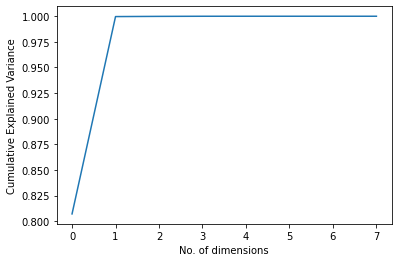

In [7]:
pca=PCA().fit(inputs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('No. of dimensions')
plt.ylabel('Cumulative Explained Variance')

### PCA

We will now reduce the dimensionality of the data (both testing and training sets)

In [8]:
pca = PCA(1)  

inputsPCA = pca.fit_transform(inputs)

In [9]:
inputsPCA.shape

(768, 1)

### Plot Some Data

We can see from the bellow plot that for these two input metrics there is wildly different scales. One is between 0.5 to 1 and the other 500 to 900.

We need to scale this data using one of sk learns scaller. We will use the  

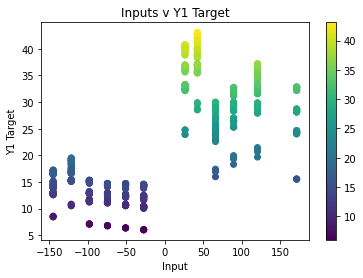

In [10]:
plt.figure()
plt.scatter(inputsPCA[:,0], targets[:,:1], c= targets[:,0])
plt.title("Inputs v Y1 Target")
plt.colorbar()
plt.xlabel('Input')
plt.ylabel('Y1 Target')
plt.show()

In [11]:
scaler = MinMaxScaler()

inputsScaled = scaler.fit_transform(inputsPCA)
inputsScaledNoPCA = scaler.fit_transform(inputs)

We can now see that the data has been scalled so the minimum target value is now 0 and the maximum target value is 1.

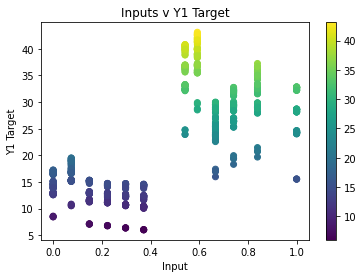

In [12]:
plt.figure()
plt.scatter(inputsScaled[:,0], targets[:,:1], c= targets[:,0])
plt.title("Inputs v Y1 Target")
plt.colorbar()
plt.xlabel('Input')
plt.ylabel('Y1 Target')
plt.show()

## Random Forest

In [49]:
rf = RandomForestRegressor()
rfCvPca = cross_validate(rf, inputsScaled, targets, cv=25, return_train_score=True, 
                         scoring='neg_mean_squared_error')

In [14]:
rf = RandomForestRegressor()
rfCvNoPca = cross_validate(rf, inputsScaledNoPCA, targets, cv=25, return_train_score=True, 
                           scoring='neg_mean_squared_error')

In [15]:
rfResultsTrain = {"RF w/ PCA - Test Score": rfCvPca['test_score'], 
                  "RF w/o PCA - Test Score": rfCvNoPca['test_score']}

rfResultsTest = {"RF w/ PCA - Train Score": rfCvPca['train_score'],
                 "RF w/o PCA - Train Score": rfCvNoPca['train_score']}

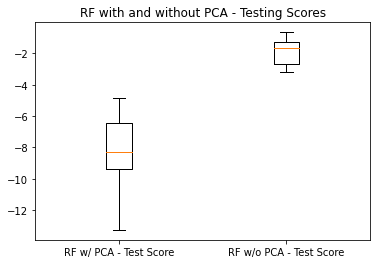

In [16]:
fig, ax = plt.subplots()
plt.title("RF with and without PCA - Testing Scores")
ax.boxplot(rfResultsTrain.values())
ax.set_xticklabels(rfResultsTrain.keys())
plt.show()

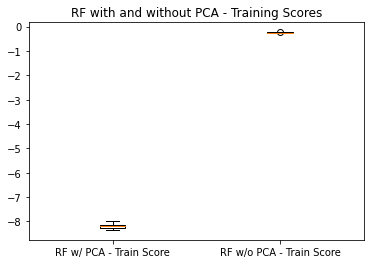

In [17]:
fig, ax = plt.subplots()
plt.title("RF with and without PCA - Training Scores")
ax.boxplot(rfResultsTest.values())
ax.set_xticklabels(rfResultsTest.keys())
plt.show()

### Random Forest Results

The random forset produced some unusual results, it performed much better on the data that had not undergone PCA compared to the data which was reduced down to 1 dimension. 

The non-reduced dataset has a much lower average error on the test data, -2 compared to -8 for the reduced dataset. It also had a much smaller IQR of around 1.8 compared to 3 for the reduced dataset.

## Neural Network

In [50]:
regressor = MLPRegressor(max_iter=15000)
nnCvPca = cross_validate(regressor, inputsScaled, targets, cv=25, return_train_score=True, 
                         scoring='neg_mean_squared_error')

In [19]:
regressor = MLPRegressor(max_iter=15000)
nnCvNoPca = cross_validate(regressor, inputsScaledNoPCA, targets, cv=25, return_train_score=True, 
                           scoring='neg_mean_squared_error')

In [20]:
nnResultsTrain = {"NN w/ PCA - Test Score": nnCvPca['test_score'], 
                  "NN w/o PCA - Test Score": nnCvNoPca['test_score']}

nnResultsTest = {"NN w/ PCA - Train Score": nnCvPca['train_score'],
                  "NN w/o PCA - Train Score": nnCvNoPca['train_score']}

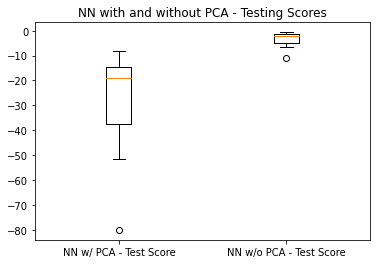

In [21]:
fig, ax = plt.subplots()
plt.title("NN with and without PCA - Testing Scores")
ax.boxplot(nnResultsTrain.values())
ax.set_xticklabels(nnResultsTrain.keys())
plt.show()

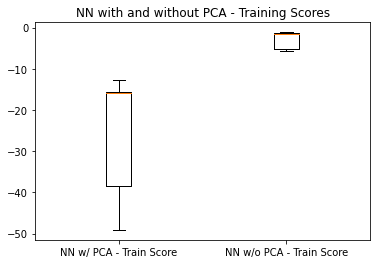

In [22]:
fig, ax = plt.subplots()
plt.title("NN with and without PCA - Training Scores")
ax.boxplot(nnResultsTest.values())
ax.set_xticklabels(nnResultsTest.keys())
plt.show()

### Neural Network Results

The neural network also produced some unusual results, again performing much better on the data that had not undergone PCA compared to the data which was reduced down to 1 dimension. 

The non-reduced dataset has a much lower average error on the test data, -2.2 compared to -20 for the reduced dataset. It also had a much smaller IQR of around 3 compared to 24 for the reduced dataset.

## Support Vector Machine

The SVM can only predict a single output variable, because our dataset has two output variables (Y1 and Y2) we need to train two seperate SVMs.

### Y1

In [51]:
svr = svm.SVR(gamma="auto")
svmCvPca_y1 = cross_validate(svr, inputsScaled, targets_y1.ravel(), cv=25, return_train_score=True, 
                           scoring='neg_mean_squared_error')

In [52]:
svr = svm.SVR(gamma="auto")
svmCvNoPca_y1 = cross_validate(svr, inputsScaledNoPCA, targets_y1.ravel(), cv=25, return_train_score=True, 
                           scoring='neg_mean_squared_error')

In [53]:
svmResultsTrain_y1 = {"SVM w/ PCA - Test Score": svmCvPca_y1['test_score'], 
                  "SVM w/o PCA - Test Score": svmCvNoPca_y1['test_score']}

svmResultsTest_y1 = {"SVM w/ PCA - Train Score": svmCvPca_y1['train_score'],
                  "SVM w/o PCA - Train Score": svmCvNoPca_y1['train_score']}

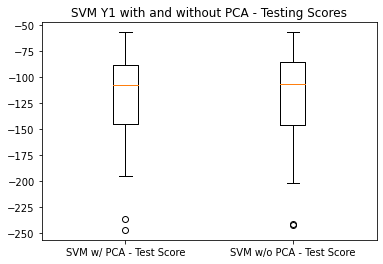

In [54]:
fig, ax = plt.subplots()
plt.title("SVM Y1 with and without PCA - Testing Scores")
ax.boxplot(svmResultsTrain_y1.values())
ax.set_xticklabels(svmResultsTrain_y1.keys())
plt.show()

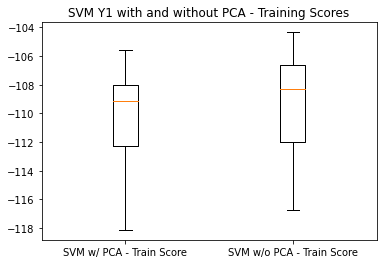

In [55]:
fig, ax = plt.subplots()
plt.title("SVM Y1 with and without PCA - Training Scores")
ax.boxplot(svmResultsTest_y1.values())
ax.set_xticklabels(svmResultsTest_y1.keys())
plt.show()

### Y2

In [56]:
svr = svm.SVR(gamma="auto")
svmCvPca_y2 = cross_validate(svr, inputsScaled, targets_y2.ravel(), cv=25, return_train_score=True, 
                           scoring='neg_mean_squared_error')

In [57]:
supportVectorMachine = svm.SVR(gamma="auto")
svmCvNoPca_y2 = cross_validate(svr, inputsScaledNoPCA, targets_y2.ravel(), cv=25, return_train_score=True, 
                           scoring='neg_mean_squared_error')

In [58]:
svmResultsTrain_y2 = {"SVM w/ PCA - Test Score": svmCvPca_y2['test_score'], 
                  "SVM w/o PCA - Test Score": svmCvNoPca_y2['test_score']}

svmResultsTest_y2 = {"SVM w/ PCA - Train Score": svmCvPca_y2['train_score'],
                  "SVM w/o PCA - Train Score": svmCvNoPca_y2['train_score']}

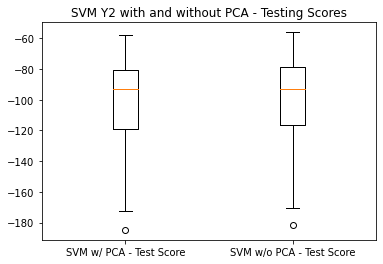

In [59]:
fig, ax = plt.subplots()
plt.title("SVM Y2 with and without PCA - Testing Scores")
ax.boxplot(svmResultsTrain_y2.values())
ax.set_xticklabels(svmResultsTrain_y2.keys())
plt.show()

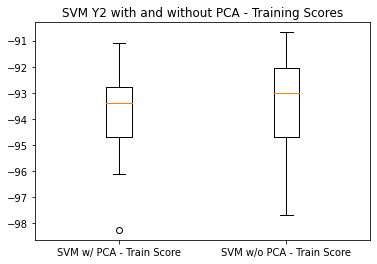

In [60]:
fig, ax = plt.subplots()
plt.title("SVM Y2 with and without PCA - Training Scores")
ax.boxplot(svmResultsTest_y2.values())
ax.set_xticklabels(svmResultsTest_y2.keys())
plt.show()

### Support Vector Machine Results

# double check

The support vector machine did not produce the same interesting results as seen with the random forest and neural network. With the average for Y1 and Y2 being approximatly -90 and -100 respectivly, with little difference between the reduced and non-reduced dataset.

Both had an IQR around thr 30 to 40 mark, again with little difference between the reduced and non reduced data.

## Overall Results

In summary the random forest is probably the best choice, it has the best average score, and a small IQR. It is also less computationaly intensive than the similarly performing neural network - the random forest takes ~3s to train vs ~25s to train the neural network.

SVM is a clear third place however, with drastically worse average scores than the neural network and random forest.

## PCA Anomalies 

It's not competly clear why the classifieres all train poorly on the reduced dataset, regardless of the CEV graph showing that 1 dimension should represent all of the variance in the data. Presumably there is some element of the data that isn't well represented when scaled down using PCA. 

# Part 2 - Optimisation

Implement an optimiser to solve a timetabling problem for a university. A file has been provided that describes modules, and lists modules against which they cannot be scheduled. A module consists of one lecture per week and one or more lab sessions.

Optimise a timetable so that session is scheduled once per week in such a way that
timetable constraints are minimised. There are 20 sessions per week. You have one lecture theatre
and two labs available.

Relevant constraints for this assessment are:

- A session cannot be scheduled for a time when any of its students or staff are in another session (concurrence constraints). The sessions for a module that clash are shown in the data file.
- A lab session cannot occur in the week before its corresponding lecture has taken place (precedence constraints).

You must design and implement a fitness function by taking the number of the concurrence constraints and multiplying them with the number of precedence constraints. This fitness function should be minimised – the ideal timetable is one with no constraint violations at all, in which case the function will return 0

## Task 2.1 – Generation of random solutions (10% of total mark)

The first task is to implement the fitness function. Your code should read the file provided and given
a timetable it should return the quality of the schedule in terms of the constraint violations, as described
above. The function should be called the fitness of a random solution printed out.

## Task 2.2 – Algorithm implementation (25% of total mark)

Implement a hillclimber to optimise the problem implemented in Task 2.1.

The algorithm must have the following features:

- It should be possible to use one of two mutation operators – one (session replace) mutates a solution by placing a session into another slot in the timetable, and the other is a ruin-andrecreate operator (which generates a completely new solution at random).
- At each iteration your single parent solution should be used to generate a single child operator by using one of the mutation operators (either the swap or the ruin-and-recreate for the entire run of the algorithm).
- At the end of an iteration the algorithm should retain the parent or child that has the best fitness.
- At the end of an iteration the best (parent or child) solution’s fitness should be added to a list of the best fitnesses, which is returned along with the best solution at the end of the optimisation.

## Task 2.3 – Visualisation of results (15% of total mark)

Run the algorithm twice for 500 iterations – once for each mutation operator. Repeat this 30 times, so that you get 30 fitness lists for the swap operator and 30 fitness lists for the ruin-andrecreate operator. 

Plot the average, maximum and minimum fitness at each iteration for each operator, plot them on the same graph so that they can be compared. 

You should be able to see which optimiser is best – state which in the notebook, and say why.

## Import the Modules